r mod 7 = 5  →  a_r = 0.5 × 5 = 2.5
r mod 5 = 1  →  b_r = 0.3 × (1 + 1) = 0.6


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim


In [3]:
df = pd.read_csv("data.csv", encoding="latin1")
df.head()


/tmp/ipython-input-3885977855.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data.csv", encoding="latin1")


,stn_code,sampling_date,state,location,agency,type,so2,no2,rspm,spm,location_monitoring_station,pm2_5,date
0,150.0,February - M021990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",4.8,17.4,NaN,NaN,NaN,NaN,1990-02-01
1,151.0,February - M021990,Andhra Pradesh,Hyderabad,NaN,Industrial Area,3.1,7.0,NaN,NaN,NaN,NaN,1990-02-01
2,152.0,February - M021990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",6.2,28.5,NaN,NaN,NaN,NaN,1990-02-01
3,150.0,March - M031990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",6.3,14.7,NaN,NaN,NaN,NaN,1990-03-01
4,151.0,March - M031990,Andhra Pradesh,Hyderabad,NaN,Industrial Area,4.7,7.5,NaN,NaN,NaN,NaN,1990-03-01


In [5]:
x = df["no2"].dropna().values
print("Number of samples:", len(x))


Number of samples: 419509


In [6]:
a_r = 2.5
b_r = 0.6

z = x + a_r * np.sin(b_r * x)
z = z.reshape(-1, 1)


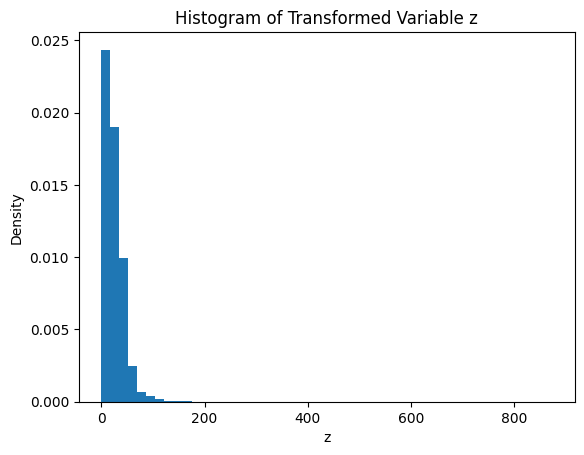

In [7]:
plt.hist(z, bins=50, density=True)
plt.xlabel("z")
plt.ylabel("Density")
plt.title("Histogram of Transformed Variable z")
plt.show()


In [9]:
z_tensor = torch.tensor(z, dtype=torch.float32)


In [10]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 16),
            nn.ReLU(),
            nn.Linear(16, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )

    def forward(self, x):
        return self.net(x)


In [11]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 16),
            nn.ReLU(),
            nn.Linear(16, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)


In [12]:
G = Generator()
D = Discriminator()

criterion = nn.BCELoss()
optimizer_G = optim.Adam(G.parameters(), lr=0.001)
optimizer_D = optim.Adam(D.parameters(), lr=0.001)


In [17]:
epochs = 10000
batch_size = 128


In [18]:
for epoch in range(epochs):
    idx = np.random.randint(0, len(z_tensor), batch_size)
    real_samples = z_tensor[idx]

    real_labels = torch.ones(batch_size, 1)
    fake_labels = torch.zeros(batch_size, 1)

    # ---- Train Discriminator ----
    noise = torch.randn(batch_size, 1)
    fake_samples = G(noise)

    loss_real = criterion(D(real_samples), real_labels)
    loss_fake = criterion(D(fake_samples.detach()), fake_labels)
    loss_D = loss_real + loss_fake

    optimizer_D.zero_grad()
    loss_D.backward()
    optimizer_D.step()

    # ---- Train Generator ----
    noise = torch.randn(batch_size, 1)
    generated = G(noise)
    loss_G = criterion(D(generated), real_labels)

    optimizer_G.zero_grad()
    loss_G.backward()
    optimizer_G.step()

    if epoch % 500 == 0:
        print(f"Epoch {epoch} | D Loss: {loss_D.item():.4f} | G Loss: {loss_G.item():.4f}")


Epoch 0 | D Loss: 1.4702 | G Loss: 0.6497
Epoch 500 | D Loss: 1.3908 | G Loss: 0.6629
Epoch 1000 | D Loss: 1.3861 | G Loss: 0.6756
Epoch 1500 | D Loss: 1.3863 | G Loss: 0.6832
Epoch 2000 | D Loss: 1.3890 | G Loss: 0.7404
Epoch 2500 | D Loss: 1.3857 | G Loss: 0.6887
Epoch 3000 | D Loss: 1.3863 | G Loss: 0.6673
Epoch 3500 | D Loss: 1.3865 | G Loss: 0.6938
Epoch 4000 | D Loss: 1.3864 | G Loss: 0.6716
Epoch 4500 | D Loss: 1.3855 | G Loss: 0.7202
Epoch 5000 | D Loss: 1.3877 | G Loss: 0.6816
Epoch 5500 | D Loss: 1.3825 | G Loss: 0.6744
Epoch 6000 | D Loss: 1.3867 | G Loss: 0.7133
Epoch 6500 | D Loss: 1.3855 | G Loss: 0.6710
Epoch 7000 | D Loss: 1.3859 | G Loss: 0.6972
Epoch 7500 | D Loss: 1.3869 | G Loss: 0.7077
Epoch 8000 | D Loss: 1.3855 | G Loss: 0.6466
Epoch 8500 | D Loss: 1.3899 | G Loss: 0.6754
Epoch 9000 | D Loss: 1.3866 | G Loss: 0.6881
Epoch 9500 | D Loss: 1.3870 | G Loss: 0.6814


In [19]:
with torch.no_grad():
    z_fake = G(torch.randn(10000, 1)).numpy()


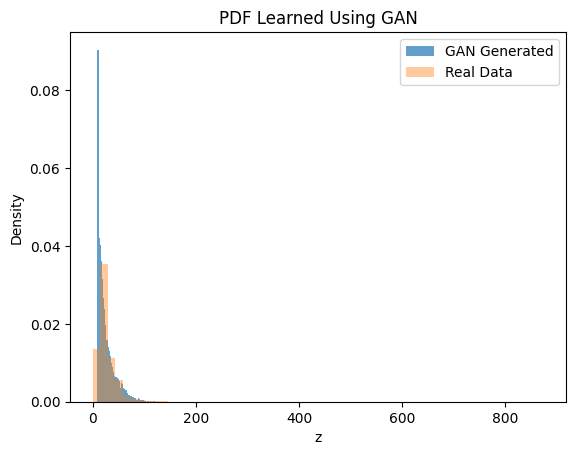

In [20]:
plt.hist(z_fake, bins=60, density=True, alpha=0.7, label="GAN Generated")
plt.hist(z, bins=60, density=True, alpha=0.4, label="Real Data")
plt.xlabel("z")
plt.ylabel("Density")
plt.title("PDF Learned Using GAN")
plt.legend()
plt.show()


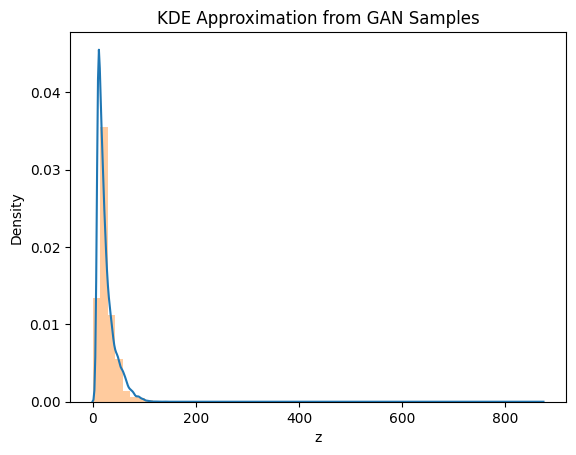

In [21]:
from scipy.stats import gaussian_kde

kde = gaussian_kde(z_fake.flatten())
z_vals = np.linspace(z.min(), z.max(), 500)

plt.plot(z_vals, kde(z_vals))
plt.hist(z, bins=60, density=True, alpha=0.4)
plt.title("KDE Approximation from GAN Samples")
plt.xlabel("z")
plt.ylabel("Density")
plt.show()


In [22]:
print("FINAL SUBMISSION DETAILS")
print("Roll Number: 102316091")
print("a_r =", a_r)
print("b_r =", b_r)
print("GAN trained on transformed samples z")


FINAL SUBMISSION DETAILS
Roll Number: 102316091
a_r = 2.5
b_r = 0.6
GAN trained on transformed samples z
